<a href="https://colab.research.google.com/github/SnoopiACK/DientesMask/blob/master/Template_matching_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
from PIL import Image
from scipy import optimize,interpolate
import numpy as np
import pandas as pd
import json
import os

repo_url = 'https://github.com/SnoopiACK/DientesMask'
!git clone {repo_url}
repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))
%cd {repo_dir_path}
!git pull

Vamos a comparar un arreglo a con un template b y ver el "offset" que hay entre ambos. En casos normales, a tiene igual o menos elementos que b.

La idea seria algo similar a obtener el retraso entre dos señales a partir del computo de su correlacion cruzada (ver la funcion xcorr de matlab!). No es exacta exacta exactamente lo mismo ya que la correlacion cruzada es una operacion de señales, y aquí se comparan arreglos de categorias. 

Este metodo funciona cuando los dientes de la imagen fueron todos clasificados de forma correcta. Ademas, dado que esta basado en una (pseudo) correlacion cruzada, deberia tambien funcionar cuando la mayoria de los dientes fueron clasificados de forma correcta.

In [0]:
def template_match(a,b):
  len_a, len_b = len(a), len(b)
  len_diffs = len_b - len_a
  num_aciertos = []
  for i in range(len_diffs + 1): #el bucle debe correr al menos una vez (caso len(b) == len(a))
    num_aciertos.append(0)
    b_aux = b[i:i+len_a]
    aciertos = [x == y for x,y in zip(a,b_aux) ]
    num_aciertos[-1] += sum(aciertos)
  res = np.argmax(num_aciertos)
  return res


a =         [2,3,4,4,4,4,3,2,2,1,1,1]
b = [1,1,1,2,2,3,4,4,4,4,3,2,2,1,1,1]

print("el arreglo a esta desplazado {} elementos respecto a b".format(template_match(a,b)))

el arreglo a esta desplazado 4 elementos respecto a b


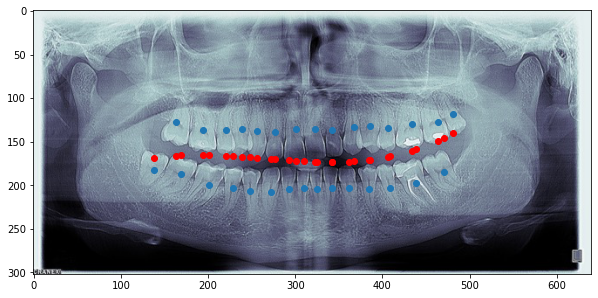

In [0]:
#clase de diente dado su numero
def get_tooth_type(tooth_number):
  if len(tooth_number) == 2:
    c = tooth_number[1]
  else:
    c = tooth_number 
  if (c == '1') or (c == '2'):
    tooth_type = 'I'
  elif (c == '3'):
    tooth_type = 'C'
  elif (c == '4') or (c == '5'):
    tooth_type = 'P'
  else:
    tooth_type = 'M'  
  return tooth_type

#abrir una panoramica previamente segmentada
json_filename = "DICROCE_SOFIA_07062017_153534 (1).json"
json_file = json.load( open(os.path.join(jsons_path, json_filename), encoding = 'cp1252' ) )#json.load( open(os.path.join(jsons_path, json_filename), encoding = 'cp1252' ) )
img_filename = json_file['imagePath']
height = json_file['imageHeight']
width = json_file['imageWidth']
teeth_list = []

#hacer lista con la posicion y tipo de los dientes que aparecen
for shape in json_file['shapes']:
  x_min, x_max = shape['points'][0][0], shape['points'][1][0]
  y_min, y_max = shape['points'][0][1], shape['points'][1][1]
  x_avg = ( x_min + x_max ) / 2
  y_avg = ( y_min + y_max ) / 2
  label = get_tooth_type(shape['label'])
  teeth_list.append( [x_avg, y_avg,label] )

#separar mandibula inferior de superior haciendo una regression fiteando test_func a los dientes
def test_func(x,a,b,c,d):
  return a*x*x*x + b*x*x + c*x + d

teeth_array = np.array(teeth_list)
teeth_xy_array = teeth_array[:,0:2].astype(float)
params, params_cov = optimize.curve_fit(test_func,teeth_xy_array[:,0], teeth_xy_array[:,1])

#mostrar imagen
img = Image.open(os.path.join('data/images', img_filename))
figure = plt.figure(figsize = (10,10))
plt.imshow(img)
plt.scatter(teeth_xy_array[:,0], teeth_xy_array[:,1])
opt_values = test_func(teeth_xy_array[:,0], params[0],params[1],params[2],params[3])
plt.scatter(teeth_xy_array[:,0], opt_values, color = 'red')

In [0]:
#se separan los dientes superiores de inferiores
upper_teeth = [x for x in teeth_list if x[1] < test_func(x[0], params[0],params[1],params[2],params[3])]
lower_teeth = [x for x in teeth_list if x[1] > test_func(x[0], params[0],params[1],params[2],params[3])]

#se ordenan de izquierda a derecha
upper_teeth.sort(key = lambda x: x[0])
lower_teeth.sort(key = lambda x: x[0])

#se hace una lista solo con la clase del diente
upper_teeth_labels = [x[2] for x in upper_teeth]
lower_teeth_labels = [x[2] for x in lower_teeth]

#lista con las etiqutes ordenadas de una mandibula sana
teeth_order = ['M','M','M','P','P','C','I','I','I','I','C','P','P','M','M','M']

#se calcula el "offset" entre las listas anteriores y la mandibula sana
upper_teeth_offset = template_match(upper_teeth_labels, teeth_order)
lower_teeth_offset = template_match(lower_teeth_labels, teeth_order)

#resultados
full_upper_teeth_numbers = ['18','17','16','15','14','13','12','11','21','22','23','24','25','26','27','28']
full_lower_teeth_numbers = ['48','47','46','45','44','43','42','41','31','32','33','34','35','36','37','38']

upper_teeth_numbers = map( lambda x: full_upper_teeth_numbers[x], list( range( upper_teeth_offset, upper_teeth_offset + len(upper_teeth_labels ) ) ) )
lower_teeth_numbers = map( lambda x: full_lower_teeth_numbers[x], list( range( lower_teeth_offset, lower_teeth_offset + len(lower_teeth_labels ) ) ) )

print(list(upper_teeth_numbers))
print(list(lower_teeth_numbers))


['17', '16', '15', '14', '13', '12', '11', '21', '22', '23', '24', '25', '26', '27', '28']
['48', '47', '46', '45', '44', '43', '42', '41', '31', '32', '33', '34', '35', '36', '37']
